In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture
from scipy.stats import norm
import os
import datetime as dt
import sys
import csv

# Pre-processing for MIDAS

In [2]:
inputfilepath = 'data/tokenTx_2tiers_all.csv'
outputfilepath = 'data/tokenTx_2tiers_all_midasformat.csv'
walletmapfilepath = 'data/tokenTx_2tiers_all_walletmap.csv'

datadf = pd.read_csv(inputfilepath, usecols=['from', 'to', 'timeStamp'])
datadf = datadf.sort_values('timeStamp')
datadf.head()

,timeStamp,from,to
129394,1497893158,0xf3d1f26b31db83c8899626746d0bbc59d9dd223c,0xc694c96f5c3e8c848d9d832b70d0ed51903f147c
115279,1497893301,0xf3d1f26b31db83c8899626746d0bbc59d9dd223c,0xaddfa4830a808bc86a4478bc33ff4f0881936735
198927,1497893345,0xf3d1f26b31db83c8899626746d0bbc59d9dd223c,0x48713ed4e4f72824dd2514a0e5ba2be1d75e5a6b
240229,1497893707,0xf3d1f26b31db83c8899626746d0bbc59d9dd223c,0x364fcdc8081107b94993aaca3cfe3c8d0c3fe699
92209,1497893760,0xf3d1f26b31db83c8899626746d0bbc59d9dd223c,0xff9f720ceea8986ad8f187a7fb265b57072cd944


In [3]:
starttime = min(datadf['timeStamp'])
timestep = 3600 # 1 hour timestep

walletmap = {}
numberid = len(walletmap)

def timestampToNumber(timestamp):
    global starttime
    return 1 + (timestamp-starttime)//timestep

def walletToNumber(hashid):
    global walletmap
    global numberid

    if hashid not in walletmap:
        walletmap[hashid] = numberid
        numberid += 1
        return (numberid-1)
    else:
        return walletmap[hashid]

In [4]:
for col in ['from', 'to']:
    datadf[col] = datadf[col].map(lambda hashid: walletToNumber(hashid))
    
datadf['timeStamp'] = datadf['timeStamp'].map(lambda timestamp: timestampToNumber(timestamp))

In [5]:
datadf

,timeStamp,from,to
129394,1,0,137
115279,1,0,74
198927,1,0,84
240229,1,0,49
92209,1,0,1275
...,...,...,...
295647,34872,6795,6464
295648,34872,6697,6464
295649,34873,7833,6464
295650,34873,6464,32301


In [6]:
datadf.to_csv(outputfilepath, index=False, columns=['from', 'to', 'timeStamp'], header=False)

In [ ]:
with open(walletmapfilepath, 'w', newline='') as f:  
    writer = csv.writer(f)
    for k, v in walletmap.items():
       writer.writerow([k, v])

# (Run MIDAS Here)

# Analysis and Post-processing of MIDAS Results

### (Skip This) Separating Etherscan and Zksync Receipts

In [3]:
fulltx = pd.read_csv('data/fullTX.csv', header=0, usecols=['timeStamp', 'hash', 'blockHash', 'from', 'to', 'value', 'tokenName'])
fulltx

,timeStamp,hash,blockHash,from,to,value,tokenName
0,1575576946,0x7b77471954162824ccc951fe229959dfc9428d15e4f3...,0x6c12bfb38d3a7538b773946ba686f8669dfb3c6a894b...,0xd57f141517a4958beafd8645816a916d88dee9e3,0x5836d1c3bf3408451d010f0a042e25e987ebd889,100000000000,Storj
1,1575577354,0x642b862ed6dbc1b29a7102a55e8bebe30a09ff38dda7...,0xd80060bde9e234a6823e860d36f8c2e9532c366ddf43...,0x5836d1c3bf3408451d010f0a042e25e987ebd889,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,100000000000,Storj
2,1577010273,0xe326eaaed320b7e8ffd3103cd61d3d92485725c232f6...,0x309d63ae895114f52816472de285bbf28fac051dbe81...,0xd57f141517a4958beafd8645816a916d88dee9e3,0x5836d1c3bf3408451d010f0a042e25e987ebd889,101477690951,Storj
3,1577010649,0x83109b2748f0c0da424e09120f8052f9f106513eae63...,0x419deae39dda9e0c713ac186228fd9dc93a04f45f5e0...,0x5836d1c3bf3408451d010f0a042e25e987ebd889,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,101477690951,Storj
4,1578264570,0x84c87d14495679adce0aef1e611f8eb4bde9495cecda...,0xa1ff434df77df50f638f740a3b719d1ee5b1935963c4...,0x10651a027af4d1a923f951191d92e58636f9550b,0x5836d1c3bf3408451d010f0a042e25e987ebd889,247797920580,Storj
...,...,...,...,...,...,...,...
492187,1559635780,0x8c9969facbb3d308471df4731f3306e4c150e271c0a0...,0x13aa0024ac244a6900d5a155d8926934f1242e766ce6...,0x00122632e9e0e257cffb4dfd977ff1e396bf3403,0x00f86c784cc13d7c2a1e2812b05cf0eef915b2e4,9151,Storj
492188,1560511248,0xcbbe4cfb2db1e73e94cacd7a8e7d217789bd6882dd56...,0xc77b57889d5007bb47cbd6c3dde0c4000857519db7ab...,0x00295596a2821b23153668b6e1c60e784fdfd02b,0x00f86c784cc13d7c2a1e2812b05cf0eef915b2e4,316614,Storj
492189,1559635780,0xf5dffcb503fb1d45d6d65f82461cc4e6fd7d3761dd86...,0x13aa0024ac244a6900d5a155d8926934f1242e766ce6...,0x00122632e9e0e257cffb4dfd977ff1e396bf3403,0x6deb0c371f807a2d57f6078e9a7dc1cc2cf3e366,1193,Storj
492190,1559635908,0x39d31dbd8c06542b4fe35f0d7c9118a8351f4e7a3f5c...,0xd4f6b8524754222f30216cd2d3ff531885607fdcf719...,0x00122632e9e0e257cffb4dfd977ff1e396bf3403,0x6afa50f642442b5dc3669143b57b294d4882a9d8,1591,Storj


In [4]:
ap_receipt = pd.read_csv('data/ap_node_payments_receipt.csv')
ap_receipt

,period,node_id,amount,receipt
0,2020-02,0004fdbcb318da82bf836494f34f8a7709c540c7b4a91d...,40948,eth:0xdea23c9b6cfc97bedd07ae2338d79394e876d6aa...
1,2020-02,0014370f3f4b5453b6de5ae01a7de7b593b264cbd94c68...,69,eth:0xdb16135195d8addc2f79e331490d5a03e066dd6d...
2,2020-02,00179c42455430dc020b874d0c4d01a08b50d52a88bfa1...,302935,eth:0x6d3b9b4aaaa7279726a83450f696dd7893282bf1...
3,2020-02,001cc70f26a75babe644cfe6d6308398bf6a56a38d9656...,19116,eth:0xaa424e0a0819f7da2b14497e92e819374d99c071...
4,2020-02,001e776079defa0808c763292c8c135f7d8ffad0d1ba0f...,2,eth:0xaab09796ba7c2a059cfeb05aa979e950d68eb961...
...,...,...,...,...
112513,2021-04,ffd84b4f2fc0792fc3e61b074b4bb03cc9626d72d2b4ec...,77,eth:0xb69f07607b2aceac97c3ec6cf5184c0d3570e8ee...
112514,2021-04,ffd90701685d349458dbf4f02961a2f62a75fc76db5951...,1144,eth:0x0742fe55cf74625d1a998026b8051470b3d1c146...
112515,2021-04,ffe4136fe375012a06ff914492bdef34aa46a32f76da2d...,222156,eth:0x5340cc82c5bde9d3db9457f57f2b70982bcb2931...
112516,2021-04,fff4130f52a706a62ac5574ee4787038205fd906cc74d8...,1634,zksync:281739e36d3db60accae568387881aff05b5075...


In [5]:
eu_receipt = pd.read_csv('data/eu_node_payments_receipt.csv')
eu_receipt

,period,node_id,amount,receipt
0,2020-02,0004fdbcb318da82bf836494f34f8a7709c540c7b4a91d...,92557,eth:0x626089e649d580b0ceecccaf9a95ca909ecdee7e...
1,2020-02,0014370f3f4b5453b6de5ae01a7de7b593b264cbd94c68...,5,eth:0xc6acc984419d2ab0ab5230c14acd068bfa0c7fdb...
2,2020-02,00179c42455430dc020b874d0c4d01a08b50d52a88bfa1...,861365,eth:0xdecd55d7d75d15c455ca1ddeed04d53a7c6d9de6...
3,2020-02,001cc70f26a75babe644cfe6d6308398bf6a56a38d9656...,42210,eth:0xcf659ebc8d220e2dfad4b0a23b9737b0c767a1aa...
4,2020-02,001e776079defa0808c763292c8c135f7d8ffad0d1ba0f...,25981,eth:0x24ef4d22bec9a7963da2df2a849f75c39f669a61...
...,...,...,...,...
113520,2021-04,ffd84b4f2fc0792fc3e61b074b4bb03cc9626d72d2b4ec...,70,eth:0xb69f07607b2aceac97c3ec6cf5184c0d3570e8ee...
113521,2021-04,ffd90701685d349458dbf4f02961a2f62a75fc76db5951...,1447,eth:0x0742fe55cf74625d1a998026b8051470b3d1c146...
113522,2021-04,ffe4136fe375012a06ff914492bdef34aa46a32f76da2d...,361927,eth:0x5340cc82c5bde9d3db9457f57f2b70982bcb2931...
113523,2021-04,fff4130f52a706a62ac5574ee4787038205fd906cc74d8...,2795,zksync:281739e36d3db60accae568387881aff05b5075...


In [6]:
us_receipt = pd.read_csv('data/us_node_payments_receipt.csv')
us_receipt

,period,node_id,amount,receipt
0,2020-02,0004fdbcb318da82bf836494f34f8a7709c540c7b4a91d...,202523,eth:0x1bd57fe8cf3f9c3f0bf06f5d35490b78d83bd112...
1,2020-02,00179c42455430dc020b874d0c4d01a08b50d52a88bfa1...,491510,eth:0xae9b1050b90504218750c71a923616c930ce9969...
2,2020-02,001cc70f26a75babe644cfe6d6308398bf6a56a38d9656...,73149,eth:0xfc5b6fc11104f6ce4db5a3b28dff0e366bb52bc1...
3,2020-02,001e776079defa0808c763292c8c135f7d8ffad0d1ba0f...,100,eth:0x0fe006a13dbb85fca3a8c4cda9c0223046c999c5...
4,2020-02,0028e453d9bf44bc16a471cf284870c1ace414ba85fb1d...,125,eth:0xcdf0729d4eb029ac397ef0f50c56d605266dc3ac...
...,...,...,...,...
113925,2021-04,ffd84b4f2fc0792fc3e61b074b4bb03cc9626d72d2b4ec...,522,eth:0xb69f07607b2aceac97c3ec6cf5184c0d3570e8ee...
113926,2021-04,ffd90701685d349458dbf4f02961a2f62a75fc76db5951...,13050,eth:0x0742fe55cf74625d1a998026b8051470b3d1c146...
113927,2021-04,ffe4136fe375012a06ff914492bdef34aa46a32f76da2d...,138108,eth:0x5340cc82c5bde9d3db9457f57f2b70982bcb2931...
113928,2021-04,fff4130f52a706a62ac5574ee4787038205fd906cc74d8...,84962,zksync:281739e36d3db60accae568387881aff05b5075...


In [7]:
receipts = pd.concat([ap_receipt, eu_receipt, us_receipt])
receipts

,period,node_id,amount,receipt
0,2020-02,0004fdbcb318da82bf836494f34f8a7709c540c7b4a91d...,40948,eth:0xdea23c9b6cfc97bedd07ae2338d79394e876d6aa...
1,2020-02,0014370f3f4b5453b6de5ae01a7de7b593b264cbd94c68...,69,eth:0xdb16135195d8addc2f79e331490d5a03e066dd6d...
2,2020-02,00179c42455430dc020b874d0c4d01a08b50d52a88bfa1...,302935,eth:0x6d3b9b4aaaa7279726a83450f696dd7893282bf1...
3,2020-02,001cc70f26a75babe644cfe6d6308398bf6a56a38d9656...,19116,eth:0xaa424e0a0819f7da2b14497e92e819374d99c071...
4,2020-02,001e776079defa0808c763292c8c135f7d8ffad0d1ba0f...,2,eth:0xaab09796ba7c2a059cfeb05aa979e950d68eb961...
...,...,...,...,...
113925,2021-04,ffd84b4f2fc0792fc3e61b074b4bb03cc9626d72d2b4ec...,522,eth:0xb69f07607b2aceac97c3ec6cf5184c0d3570e8ee...
113926,2021-04,ffd90701685d349458dbf4f02961a2f62a75fc76db5951...,13050,eth:0x0742fe55cf74625d1a998026b8051470b3d1c146...
113927,2021-04,ffe4136fe375012a06ff914492bdef34aa46a32f76da2d...,138108,eth:0x5340cc82c5bde9d3db9457f57f2b70982bcb2931...
113928,2021-04,fff4130f52a706a62ac5574ee4787038205fd906cc74d8...,84962,zksync:281739e36d3db60accae568387881aff05b5075...


In [8]:
receipts[['receipt_type', 'receipt_hash']] = receipts['receipt'].str.split(':',1, expand=True)
eth_receipts = receipts[receipts['receipt_type']=='eth']
eth_receipts

,period,node_id,amount,receipt,receipt_type,receipt_hash
0,2020-02,0004fdbcb318da82bf836494f34f8a7709c540c7b4a91d...,40948,eth:0xdea23c9b6cfc97bedd07ae2338d79394e876d6aa...,eth,0xdea23c9b6cfc97bedd07ae2338d79394e876d6aaebdb...
1,2020-02,0014370f3f4b5453b6de5ae01a7de7b593b264cbd94c68...,69,eth:0xdb16135195d8addc2f79e331490d5a03e066dd6d...,eth,0xdb16135195d8addc2f79e331490d5a03e066dd6d6207...
2,2020-02,00179c42455430dc020b874d0c4d01a08b50d52a88bfa1...,302935,eth:0x6d3b9b4aaaa7279726a83450f696dd7893282bf1...,eth,0x6d3b9b4aaaa7279726a83450f696dd7893282bf1fb73...
3,2020-02,001cc70f26a75babe644cfe6d6308398bf6a56a38d9656...,19116,eth:0xaa424e0a0819f7da2b14497e92e819374d99c071...,eth,0xaa424e0a0819f7da2b14497e92e819374d99c0719913...
4,2020-02,001e776079defa0808c763292c8c135f7d8ffad0d1ba0f...,2,eth:0xaab09796ba7c2a059cfeb05aa979e950d68eb961...,eth,0xaab09796ba7c2a059cfeb05aa979e950d68eb961eb80...
...,...,...,...,...,...,...
113924,2021-04,ffd53a39db9881a2913ebd85eb81c4c72a52bc2878f08a...,79549,eth:0x764a56bb3b5e81fdc4366554a773d6c02e0b499a...,eth,0x764a56bb3b5e81fdc4366554a773d6c02e0b499a137c...
113925,2021-04,ffd84b4f2fc0792fc3e61b074b4bb03cc9626d72d2b4ec...,522,eth:0xb69f07607b2aceac97c3ec6cf5184c0d3570e8ee...,eth,0xb69f07607b2aceac97c3ec6cf5184c0d3570e8eee27e...
113926,2021-04,ffd90701685d349458dbf4f02961a2f62a75fc76db5951...,13050,eth:0x0742fe55cf74625d1a998026b8051470b3d1c146...,eth,0x0742fe55cf74625d1a998026b8051470b3d1c146e91e...
113927,2021-04,ffe4136fe375012a06ff914492bdef34aa46a32f76da2d...,138108,eth:0x5340cc82c5bde9d3db9457f57f2b70982bcb2931...,eth,0x5340cc82c5bde9d3db9457f57f2b70982bcb2931aac0...


In [9]:
receipts_tx = pd.merge(fulltx, eth_receipts, how='inner', left_on='hash', right_on='receipt_hash')
receipts_tx

,timeStamp,hash,blockHash,from,to,value,tokenName,period,node_id,amount,receipt,receipt_type,receipt_hash
0,1594153122,0xd901d7314a94b62260dbfad486bbbfc1dcfc232c4aec...,0xa9be7be924ab271a37f9f6899a5e378b9b567f3c9bf6...,0x303edcd8dbe1607fe512d45cc15d3e41fa4db44b,0x5836d1c3bf3408451d010f0a042e25e987ebd889,859005993,Storj,2020-06,8beb823ba8e5924eabd2f2e8ec2354ba9cd63da113f441...,173769,eth:0xd901d7314a94b62260dbfad486bbbfc1dcfc232c...,eth,0xd901d7314a94b62260dbfad486bbbfc1dcfc232c4aec...
1,1594153122,0xd901d7314a94b62260dbfad486bbbfc1dcfc232c4aec...,0xa9be7be924ab271a37f9f6899a5e378b9b567f3c9bf6...,0x303edcd8dbe1607fe512d45cc15d3e41fa4db44b,0x5836d1c3bf3408451d010f0a042e25e987ebd889,859005993,Storj,2020-06,a8349a31f27bf4cc8832d214d251c24b66cd5fd9bc08c6...,68,eth:0xd901d7314a94b62260dbfad486bbbfc1dcfc232c...,eth,0xd901d7314a94b62260dbfad486bbbfc1dcfc232c4aec...
2,1594153122,0xd901d7314a94b62260dbfad486bbbfc1dcfc232c4aec...,0xa9be7be924ab271a37f9f6899a5e378b9b567f3c9bf6...,0x303edcd8dbe1607fe512d45cc15d3e41fa4db44b,0x5836d1c3bf3408451d010f0a042e25e987ebd889,859005993,Storj,2020-06,8beb823ba8e5924eabd2f2e8ec2354ba9cd63da113f441...,920498,eth:0xd901d7314a94b62260dbfad486bbbfc1dcfc232c...,eth,0xd901d7314a94b62260dbfad486bbbfc1dcfc232c4aec...
3,1594153122,0xd901d7314a94b62260dbfad486bbbfc1dcfc232c4aec...,0xa9be7be924ab271a37f9f6899a5e378b9b567f3c9bf6...,0x303edcd8dbe1607fe512d45cc15d3e41fa4db44b,0x5836d1c3bf3408451d010f0a042e25e987ebd889,859005993,Storj,2020-06,a8349a31f27bf4cc8832d214d251c24b66cd5fd9bc08c6...,113,eth:0xd901d7314a94b62260dbfad486bbbfc1dcfc232c...,eth,0xd901d7314a94b62260dbfad486bbbfc1dcfc232c4aec...
4,1594153122,0xd901d7314a94b62260dbfad486bbbfc1dcfc232c4aec...,0xa9be7be924ab271a37f9f6899a5e378b9b567f3c9bf6...,0x303edcd8dbe1607fe512d45cc15d3e41fa4db44b,0x5836d1c3bf3408451d010f0a042e25e987ebd889,859005993,Storj,2020-06,8beb823ba8e5924eabd2f2e8ec2354ba9cd63da113f441...,144671,eth:0xd901d7314a94b62260dbfad486bbbfc1dcfc232c...,eth,0xd901d7314a94b62260dbfad486bbbfc1dcfc232c4aec...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
322834,1594154959,0x4003a317b809024366f13c066706c83cc4d72940153c...,0xbfa4e6cff756c40bcd68ffd8410042b373911ac15df7...,0x303edcd8dbe1607fe512d45cc15d3e41fa4db44b,0x802a15a185de4b1c613e47177bb8e83842193d0c,7642123441,Storj,2020-06,cdff0c0a2a0e99f0cf3348ac51ccbcac40ad2fb095d28b...,5061212,eth:0x4003a317b809024366f13c066706c83cc4d72940...,eth,0x4003a317b809024366f13c066706c83cc4d72940153c...
322835,1594154959,0x4003a317b809024366f13c066706c83cc4d72940153c...,0xbfa4e6cff756c40bcd68ffd8410042b373911ac15df7...,0x303edcd8dbe1607fe512d45cc15d3e41fa4db44b,0x802a15a185de4b1c613e47177bb8e83842193d0c,7642123441,Storj,2020-06,cdff0c0a2a0e99f0cf3348ac51ccbcac40ad2fb095d28b...,1974645,eth:0x4003a317b809024366f13c066706c83cc4d72940...,eth,0x4003a317b809024366f13c066706c83cc4d72940153c...
322836,1596570876,0x3aa1c1bdeb03346314e139c04c7e83a5f19d1a6a9712...,0xb46690729314aa38ebc5a204f713d74b42676a18e685...,0x303edcd8dbe1607fe512d45cc15d3e41fa4db44b,0x802a15a185de4b1c613e47177bb8e83842193d0c,6888147123,Storj,2020-07,cdff0c0a2a0e99f0cf3348ac51ccbcac40ad2fb095d28b...,1960774,eth:0x3aa1c1bdeb03346314e139c04c7e83a5f19d1a6a...,eth,0x3aa1c1bdeb03346314e139c04c7e83a5f19d1a6a9712...
322837,1596570876,0x3aa1c1bdeb03346314e139c04c7e83a5f19d1a6a9712...,0xb46690729314aa38ebc5a204f713d74b42676a18e685...,0x303edcd8dbe1607fe512d45cc15d3e41fa4db44b,0x802a15a185de4b1c613e47177bb8e83842193d0c,6888147123,Storj,2020-07,cdff0c0a2a0e99f0cf3348ac51ccbcac40ad2fb095d28b...,4724758,eth:0x3aa1c1bdeb03346314e139c04c7e83a5f19d1a6a...,eth,0x3aa1c1bdeb03346314e139c04c7e83a5f19d1a6a9712...


In [2]:
# Company wallet: 0x303EDCD8DbE1607fe512D45CC15d3E41fa4db44B

In [10]:
receipts_tx['from'].value_counts()

0x303edcd8dbe1607fe512d45cc15d3e41fa4db44b    237536
0x2d5fc0cdef7b5c020087b228c76fb3fddae8cbf2     28156
0xcf2d4537c7959fd0c381b05d6b98746d507e87dc     22379
0x42c23e580df26fbf338c99f11562f23e5abaf788     21337
0x66f0b890c2bf6d71756f03fd3b2aad18b39775ec     13431
Name: from, dtype: int64

In [11]:
receipts_tx[receipts_tx['from']!='0x303edcd8dbe1607fe512d45cc15d3e41fa4db44b']

,timeStamp,hash,blockHash,from,to,value,tokenName,period,node_id,amount,receipt,receipt_type,receipt_hash
709,1583795082,0x3567be2fefd9c4aebfb0cee610ff224d292e88f3f5ad...,0x99b86979aabe4030151fef4bd3d5db3bdf0bd6fa0377...,0x42c23e580df26fbf338c99f11562f23e5abaf788,0x37c611913ac8a0f3004e3180606720bf186588d6,416515687,Storj,2020-02,1252dd220d8d4c86b16c699f4c966e703645c8e9ca6fd6...,509077,eth:0x3567be2fefd9c4aebfb0cee610ff224d292e88f3...,eth,0x3567be2fefd9c4aebfb0cee610ff224d292e88f3f5ad...
710,1583795143,0x2f517d0d4b57707ef255df204d4b7c543a2d09288d87...,0xba82ffea51b34c477c725e88b46fbb76bd953a8ff8cf...,0xcf2d4537c7959fd0c381b05d6b98746d507e87dc,0x37c611913ac8a0f3004e3180606720bf186588d6,460907579,Storj,2020-02,1252dd220d8d4c86b16c699f4c966e703645c8e9ca6fd6...,563334,eth:0x2f517d0d4b57707ef255df204d4b7c543a2d0928...,eth,0x2f517d0d4b57707ef255df204d4b7c543a2d09288d87...
711,1583795302,0xd196d4b6a2e237a7ee7f1368a85b8910f6e4d12cfd73...,0x1413d69e0695abb9e9f6b1770895d7e9269adc0ab6e3...,0x2d5fc0cdef7b5c020087b228c76fb3fddae8cbf2,0x37c611913ac8a0f3004e3180606720bf186588d6,239043013,Storj,2020-02,1252dd220d8d4c86b16c699f4c966e703645c8e9ca6fd6...,292297,eth:0xd196d4b6a2e237a7ee7f1368a85b8910f6e4d12c...,eth,0xd196d4b6a2e237a7ee7f1368a85b8910f6e4d12cfd73...
712,1583795366,0x006f42186400acb72889ce6e0f84362da3b2ada18b22...,0xe3a8c67f3c2ff580627e1a5d755c5bc4dfe17fbcd2df...,0x42c23e580df26fbf338c99f11562f23e5abaf788,0x37c611913ac8a0f3004e3180606720bf186588d6,497240417,Storj,2020-02,16ed54b9315efba5398ba63ce6aaaaedff8692edc00da3...,607741,eth:0x006f42186400acb72889ce6e0f84362da3b2ada1...,eth,0x006f42186400acb72889ce6e0f84362da3b2ada18b22...
713,1583795409,0x3e02d42b3fef87e2acebc5570a1f608a147216083894...,0xfe5a28797aa7846a760af3fbe764ac1bbed6367676f7...,0xcf2d4537c7959fd0c381b05d6b98746d507e87dc,0x37c611913ac8a0f3004e3180606720bf186588d6,455649148,Storj,2020-02,16ed54b9315efba5398ba63ce6aaaaedff8692edc00da3...,556907,eth:0x3e02d42b3fef87e2acebc5570a1f608a14721608...,eth,0x3e02d42b3fef87e2acebc5570a1f608a147216083894...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
322828,1588953671,0xcba9dad8f4b9c69622b2dc2c1706692f3f9b75ffbe77...,0x1dc6cab94f2942366a539bc76a2ab63277b707ddf9df...,0xcf2d4537c7959fd0c381b05d6b98746d507e87dc,0x802a15a185de4b1c613e47177bb8e83842193d0c,3701468532,Storj,2020-04,cdff0c0a2a0e99f0cf3348ac51ccbcac40ad2fb095d28b...,3995781,eth:0xcba9dad8f4b9c69622b2dc2c1706692f3f9b75ff...,eth,0xcba9dad8f4b9c69622b2dc2c1706692f3f9b75ffbe77...
322829,1588967396,0x3c5cfd3595151009a7a3a1e6861c722afd2b2bc7f6c5...,0x5d42448c37d749677439e4d783d85af612ed1f95bc67...,0x42c23e580df26fbf338c99f11562f23e5abaf788,0x802a15a185de4b1c613e47177bb8e83842193d0c,1195177700,Storj,2020-04,cdff0c0a2a0e99f0cf3348ac51ccbcac40ad2fb095d28b...,1309911,eth:0x3c5cfd3595151009a7a3a1e6861c722afd2b2bc7...,eth,0x3c5cfd3595151009a7a3a1e6861c722afd2b2bc7f6c5...
322830,1591734166,0x5120fb6008bb1cb5c140667c9362f3395848e0102a2b...,0x5eaa9635bd707fbbdc7bc6078131d675eff5005b0b87...,0xcf2d4537c7959fd0c381b05d6b98746d507e87dc,0x802a15a185de4b1c613e47177bb8e83842193d0c,2564466763,Storj,2020-05,cdff0c0a2a0e99f0cf3348ac51ccbcac40ad2fb095d28b...,3607763,eth:0x5120fb6008bb1cb5c140667c9362f3395848e010...,eth,0x5120fb6008bb1cb5c140667c9362f3395848e0102a2b...
322831,1591762336,0xced7883b7302adb130188fb7be137c445d3353f3751d...,0xae63234552add976f4973d0a17e38d82ac653a535c78...,0x42c23e580df26fbf338c99f11562f23e5abaf788,0x802a15a185de4b1c613e47177bb8e83842193d0c,1062345763,Storj,2020-05,cdff0c0a2a0e99f0cf3348ac51ccbcac40ad2fb095d28b...,1539416,eth:0xced7883b7302adb130188fb7be137c445d3353f3...,eth,0xced7883b7302adb130188fb7be137c445d3353f3751d...


In [15]:
zk_receipts = receipts[receipts['receipt_type']=='zksync']
zk_receipts

,period,node_id,amount,receipt,receipt_type,receipt_hash
93078,2021-02,016d3bc16809cd1e5155023eb5f35e9cfac58cd962eefb...,2178361,zksync:0xddcc45d51643008c585f490b411a641a40e0a...,zksync,0xddcc45d51643008c585f490b411a641a40e0ad19df24...
93088,2021-02,01d3778aae484a9e68e06b922fa1d8ddc46164d7c72fa6...,1049,zksync:0xf7bb1149907441f0207e9e1c6e8cca84fde86...,zksync,0xf7bb1149907441f0207e9e1c6e8cca84fde86bb4174b...
93142,2021-02,038ca3f383e3af8a672955487dfb13d1a8f3a414354673...,779764,zksync:0x9bb50ea7ddb077b340a6775ea467473dd4ef3...,zksync,0x9bb50ea7ddb077b340a6775ea467473dd4ef3dfe1637...
93148,2021-02,03f066a2216ae72bb1ff459234a698b25427296d6b8b25...,64,zksync:0x9bb50ea7ddb077b340a6775ea467473dd4ef3...,zksync,0x9bb50ea7ddb077b340a6775ea467473dd4ef3dfe1637...
93168,2021-02,049aa8548c63eef4201dd406a5ab95088acbf450620ce9...,7642513,zksync:0x5a715491a5b5c2b814dd6a0240714d8f1c09e...,zksync,0x5a715491a5b5c2b814dd6a0240714d8f1c09ecd15a4b...
...,...,...,...,...,...,...
113886,2021-04,febecf766162c2bd4a08995edc87ec22ad9dcc172518f9...,72422,zksync:bb33828c5949cd807b9a7ec996a3c5714f4dd58...,zksync,bb33828c5949cd807b9a7ec996a3c5714f4dd581ade8b9...
113889,2021-04,fedef8a7a1decf14c0c1fa848c8ab7afdcb7340f7f6c5d...,212,zksync:05c77fcbb0e263ff47ab7a54ba87c33154248de...,zksync,05c77fcbb0e263ff47ab7a54ba87c33154248de3b7d217...
113900,2021-04,ff30bdf66d344334fe57928205d155afec214255fede82...,166904,zksync:d53e8ccb173943abbc9798d25d8d2500b923ee7...,zksync,d53e8ccb173943abbc9798d25d8d2500b923ee72fc690c...
113901,2021-04,ff41800314deb1be32ceb1e6bae4be22776d409b925b92...,411306,zksync:945dd170e72e56201dfe2a4c182fb3f55ac24e2...,zksync,945dd170e72e56201dfe2a4c182fb3f55ac24e284f7998...


In [26]:
zk_receipts['receipt_hash'].reset_index(drop=True)[7667]

'281739e36d3db60accae568387881aff05b507503974baa964f39bc1bbe6653d'

### (Skip This) MIDAS Analysis of Old 1st-Tier Token Tx

In [29]:
txdata = pd.read_csv('data/txMaster_midasformat.csv', header=None, names=['source', 'dest', 'time'])
txdata

,source,dest,time
0,0,6,1
1,1,4,418
2,1,4,595
3,2,12960,1196
4,2,12960,1196
...,...,...,...
255402,5596,10069,43751
255403,12957,7487,43751
255404,12958,7487,43752
255405,7487,12958,43752


<AxesSubplot:ylabel='Frequency'>

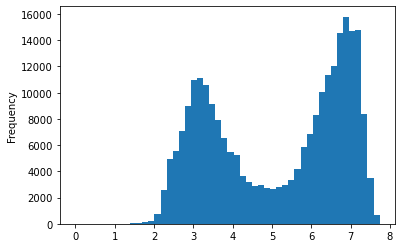

In [30]:
data_midas = pd.read_csv('data/txMaster-RCore-factor0.75-max.txt', header=None, names=['score'])
data_midas['logscore'] = np.log10(data_midas['score']+1)
data_midas['logscore'].plot.hist(bins=50)

In [46]:
txdata['dest'].value_counts()

2080     4601
6362     3812
1621     3530
70       3452
132      2418
         ... 
8767        1
21169       1
19122       1
17075       1
4094        1
Name: dest, Length: 15064, dtype: int64

In [86]:
susindex = data_midas['logscore'] > 5
sustx = txdata[susindex].reset_index(drop=True)
susdest = sustx.groupby(['dest']).count().reset_index()
susdest

,dest,source,time
0,2,68,68
1,3,151,151
2,6,129,129
3,7,76,76
4,8,132,132
...,...,...,...
4283,21805,1,1
4284,22400,1,1
4285,22401,1,1
4286,22402,1,1


In [87]:
sustx['dest'].value_counts()

2080     4321
6362     3793
5433     1479
1801      894
6315      830
         ... 
1132        1
4428        1
19813       1
12232       1
19799       1
Name: dest, Length: 4288, dtype: int64

In [88]:
sustx[sustx['dest']==2080]

,source,dest,time
740,86,2080,12857
742,86,2080,12857
1712,2178,2080,18037
1987,2364,2080,18781
1988,2364,2080,18781
...,...,...,...
138558,6804,2080,39644
140083,6804,2080,40378
140086,6804,2080,40378
140321,6804,2080,41721


In [48]:
sustx

,source,dest,time
227,64,12997,9222
228,64,2309,9222
233,64,153,9223
697,86,13029,9520
698,86,13030,9520
...,...,...,...
252879,6804,15380,43259
252880,6804,11408,43259
252881,6804,5549,43259
252882,6804,4935,43259


<AxesSubplot:ylabel='Frequency'>

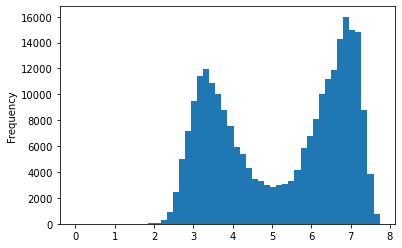

In [20]:
data_midas = pd.read_csv('data/txMaster-RCore-factor0.75-sum.txt', header=None, names=['score'])
data_midas['logscore'] = np.log10(data_midas['score']+1)
data_midas['logscore'].plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

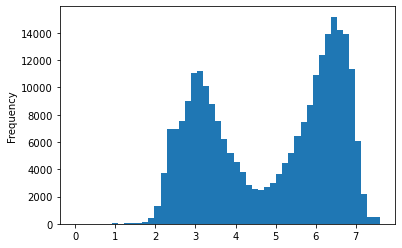

In [21]:
data_midas = pd.read_csv('data/txMaster-RCore-factor0.50-max.txt', header=None, names=['score'])
data_midas['logscore'] = np.log10(data_midas['score']+1)
data_midas['logscore'].plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

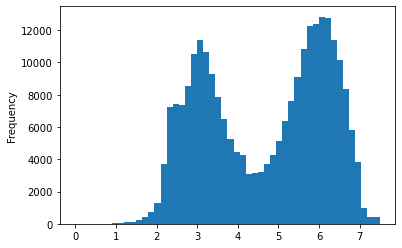

In [22]:
data_midas = pd.read_csv('data/txMaster-RCore-factor0.25-max.txt', header=None, names=['score'])
data_midas['logscore'] = np.log10(data_midas['score']+1)
data_midas['logscore'].plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

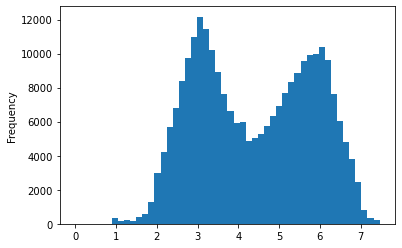

In [26]:
data_midas = pd.read_csv('data/txMaster-RCore-factor0-max.txt', header=None, names=['score'])
data_midas['logscore'] = np.log10(data_midas['score']+1)
data_midas['logscore'].plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

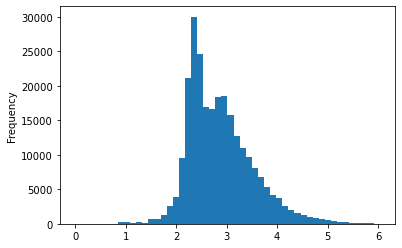

In [24]:
data_midas = pd.read_csv('data/txMaster-NCore.txt', header=None, names=['score'])
data_midas['logscore'] = np.log10(data_midas['score']+1)
data_midas['logscore'].plot.hist(bins=50)

### (Skip This) MIDAS Analysis of Previous 2-Tiers Token Tx

<AxesSubplot:ylabel='Frequency'>

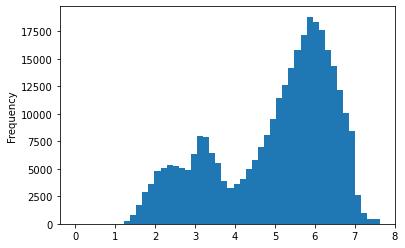

In [44]:
data_midas = pd.read_csv('data/tokenTx2tiers-RCore-factor0.1-max.txt', header=None, names=['score'])
data_midas['logscore'] = np.log10(data_midas['score']+1)
data_midas['logscore'].plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

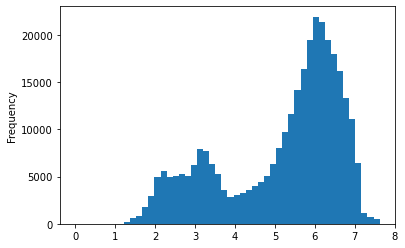

In [3]:
data_midas = pd.read_csv('data/tokenTx2tiers-RCore-factor0.25-max.txt', header=None, names=['score'])
data_midas['logscore'] = np.log10(data_midas['score']+1)
data_midas['logscore'].plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

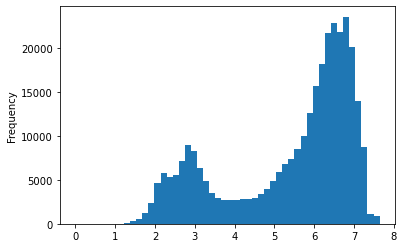

In [4]:
data_midas = pd.read_csv('data/tokenTx2tiers-RCore-factor0.5-max.txt', header=None, names=['score'])
data_midas['logscore'] = np.log10(data_midas['score']+1)
data_midas['logscore'].plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

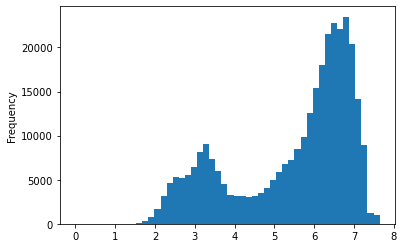

In [5]:
data_midas = pd.read_csv('data/tokenTx2tiers-RCore-factor0.5-sum.txt', header=None, names=['score'])
data_midas['logscore'] = np.log10(data_midas['score']+1)
data_midas['logscore'].plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

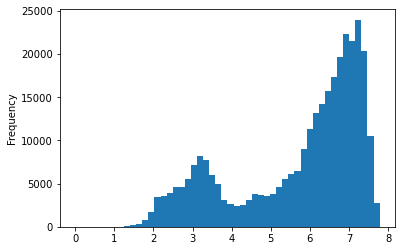

In [6]:
data_midas = pd.read_csv('data/tokenTx2tiers-RCore-factor0.75-max.txt', header=None, names=['score'])
data_midas['logscore'] = np.log10(data_midas['score']+1)
data_midas['logscore'].plot.hist(bins=50)

### MIDAS Analysis of 2-Tiers Token Tx Including Wallets from Zksync Receipts

<AxesSubplot:ylabel='Frequency'>

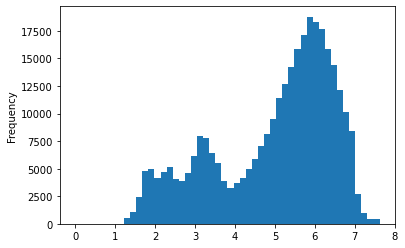

In [3]:
data_midas = pd.read_csv('data/tokenTx2tiersall-RCore-factor0.1-max.txt', header=None, names=['score'])
data_midas['logscore'] = np.log10(data_midas['score']+1)
data_midas['logscore'].plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

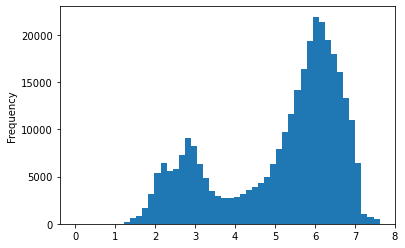

In [4]:
data_midas = pd.read_csv('data/tokenTx2tiersall-RCore-factor0.25-max.txt', header=None, names=['score'])
data_midas['logscore'] = np.log10(data_midas['score']+1)
data_midas['logscore'].plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

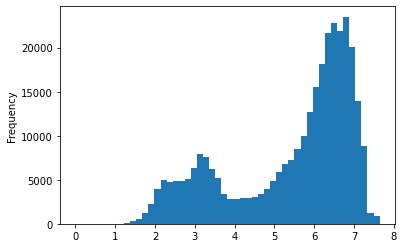

In [5]:
data_midas = pd.read_csv('data/tokenTx2tiersall-RCore-factor0.5-max.txt', header=None, names=['score'])
data_midas['logscore'] = np.log10(data_midas['score']+1)
data_midas['logscore'].plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

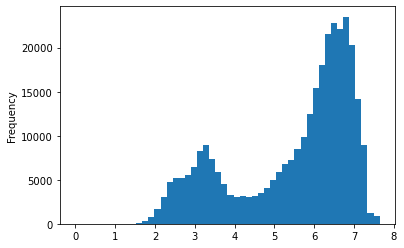

In [6]:
data_midas = pd.read_csv('data/tokenTx2tiersall-RCore-factor0.5-sum.txt', header=None, names=['score'])
data_midas['logscore'] = np.log10(data_midas['score']+1)
data_midas['logscore'].plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

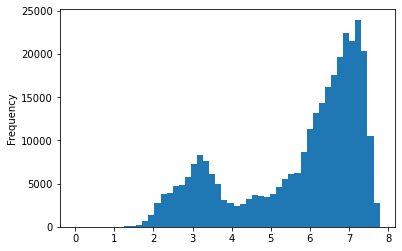

In [8]:
data_midas = pd.read_csv('data/tokenTx2tiersall-RCore-factor0.75-max.txt', header=None, names=['score'])
data_midas['logscore'] = np.log10(data_midas['score']+1)
data_midas['logscore'].plot.hist(bins=50)

### Further Analysis on the Selected MIDAS Scores

<AxesSubplot:ylabel='Frequency'>

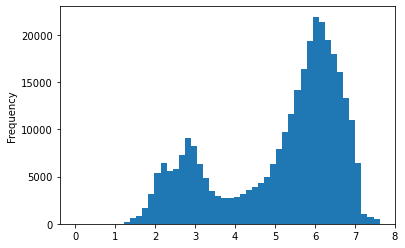

In [3]:
data_midas = pd.read_csv('data/tokenTx2tiersall-RCore-factor0.25-max.txt', header=None, names=['score'])
data_midas['logscore'] = np.log10(data_midas['score']+1)
data_midas['logscore'].plot.hist(bins=50)

In [4]:
txdata = pd.read_csv('data/tokenTx_2tiers_all_midasformat.csv', header=None, names=['source', 'dest', 'time'])
susindex = data_midas['logscore'] > 4
sustx = txdata[susindex].reset_index(drop=True)
susdest = sustx.groupby(['dest']).count().reset_index()
susdest

,dest,source,time
0,5,6,6
1,6,2,2
2,8,2,2
3,10,1,1
4,13,7,7
...,...,...,...
15906,32225,1,1
15907,32226,1,1
15908,32227,1,1
15909,32228,1,1


In [5]:
len(txdata)

316124

<AxesSubplot:>

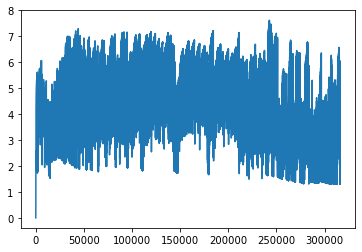

In [6]:
# Checking if there is any unexpected trend that might indicate an error happening in the midas process
data_midas['logscore'].plot()

In [7]:
data_midas['logscore'].nlargest(10)

242642    7.619534
242641    7.619255
242640    7.618976
242639    7.618697
242638    7.618418
242637    7.618138
242636    7.617858
242635    7.617578
242634    7.617298
242633    7.617018
Name: logscore, dtype: float64

In [8]:
idx = data_midas[data_midas['logscore'] == data_midas['logscore'].nlargest(10).iloc[0]].index.item()
print(txdata.iloc[idx,:])
max_source = txdata.iloc[idx,:]['source']
max_dest = txdata.iloc[idx,:]['dest']
max_sustime = txdata.iloc[idx,:]['time']
txdata[(txdata['source']==max_source) & (txdata['dest']==max_dest)]

source     6385
dest      22392
time      26739
Name: 242642, dtype: int64


,source,dest,time
242642,6385,22392,26739
248507,6385,22392,27411
257581,6385,22392,28259
264281,6385,22392,28926
271501,6385,22392,29581
275586,6385,22392,29790
280519,6385,22392,30423
291541,6385,22392,31928
296187,6385,22392,32501
309658,6385,22392,34016


In [9]:
idx = data_midas[data_midas['logscore'] == data_midas['logscore'].nlargest(10).iloc[1]].index.item()
print(txdata.iloc[idx,:])
max_source = txdata.iloc[idx,:]['source']
max_dest = txdata.iloc[idx,:]['dest']
max_sustime = txdata.iloc[idx,:]['time']
txdata[(txdata['source']==max_source) & (txdata['dest']==max_dest)]

source     6385
dest      24812
time      26739
Name: 242641, dtype: int64


,source,dest,time
242641,6385,24812,26739
248521,6385,24812,27411
257588,6385,24812,28259
264301,6385,24812,28926
271508,6385,24812,29581
276190,6385,24812,29832
280528,6385,24812,30423


In [10]:
idx = data_midas[data_midas['logscore'] == data_midas['logscore'].nlargest(10).iloc[2]].index.item()
print(txdata.iloc[idx,:])
max_source = txdata.iloc[idx,:]['source']
max_dest = txdata.iloc[idx,:]['dest']
max_sustime = txdata.iloc[idx,:]['time']
txdata[(txdata['source']==max_source) & (txdata['dest']==max_dest)]

source     6385
dest      25943
time      26739
Name: 242640, dtype: int64


,source,dest,time
242640,6385,25943,26739


In [11]:
idx = data_midas[data_midas['logscore'] == data_midas['logscore'].nlargest(10).iloc[3]].index.item()
print(txdata.iloc[idx,:])
max_source = txdata.iloc[idx,:]['source']
max_dest = txdata.iloc[idx,:]['dest']
max_sustime = txdata.iloc[idx,:]['time']
txdata[(txdata['source']==max_source) & (txdata['dest']==max_dest)]

source     6385
dest         41
time      26739
Name: 242639, dtype: int64


,source,dest,time
242639,6385,41,26739
248516,6385,41,27411
257586,6385,41,28259
264307,6385,41,28926
271512,6385,41,29581
280525,6385,41,30423
296128,6385,41,32501
314460,6385,41,34704


In [12]:
idx = data_midas[data_midas['logscore'] == data_midas['logscore'].nlargest(10).iloc[4]].index.item()
print(txdata.iloc[idx,:])
max_source = txdata.iloc[idx,:]['source']
max_dest = txdata.iloc[idx,:]['dest']
max_sustime = txdata.iloc[idx,:]['time']
txdata[(txdata['source']==max_source) & (txdata['dest']==max_dest)]

source     6385
dest       3517
time      26739
Name: 242638, dtype: int64


,source,dest,time
242638,6385,3517,26739
248519,6385,3517,27411
257590,6385,3517,28259
264296,6385,3517,28926
271519,6385,3517,29581
275348,6385,3517,29787
280538,6385,3517,30423
286801,6385,3517,31158
291539,6385,3517,31928
295223,6385,3517,32501


It is observed that a lot of the txns that are highly scored by MIDAS algorithm are just first-time txns that appear to be anomalous to MIDAS simply because there were no historical txns between the corresponding pairs of wallets. Hence, we will remove these txns and manually assign their probability of cheating to zero. This a simplification but a reasonable one since we can't be certain that a wallet is a cheater's wallet based on just one transaction.

#### Excluding first-time txns and assigning their cheating probability to zero

In [13]:
txdata

,source,dest,time
0,0,137,1
1,0,74,1
2,0,84,1
3,0,49,1
4,0,1275,1
...,...,...,...
316119,6795,6464,34872
316120,6697,6464,34872
316121,7833,6464,34873
316122,6464,32301,34873


In [14]:
txdata_first = txdata.groupby(['source', 'dest'], as_index=False).first()
txdata_first

,source,dest,time
0,0,4,4
1,0,10,3
2,0,13,1
3,0,14,73
4,0,19,1
...,...,...,...
95771,14602,14629,34855
95772,14602,32294,34855
95773,14602,32295,34856
95774,14603,32296,34857


In [15]:
txdata = txdata.merge(txdata_first, how='left', on=['source', 'dest', 'time'], indicator='first_txn')
txdata['first_txn'] = np.where(txdata['first_txn'] == 'both', True, False)
txdata

,source,dest,time,first_txn
0,0,137,1,True
1,0,74,1,True
2,0,84,1,True
3,0,49,1,True
4,0,1275,1,True
...,...,...,...,...
316119,6795,6464,34872,False
316120,6697,6464,34872,False
316121,7833,6464,34873,False
316122,6464,32301,34873,True


In [16]:
txdata['anomaly_prob'] = np.nan
txdata.loc[txdata['first_txn'],['anomaly_prob']] = 0
txdata

,source,dest,time,first_txn,anomaly_prob
0,0,137,1,True,0.0
1,0,74,1,True,0.0
2,0,84,1,True,0.0
3,0,49,1,True,0.0
4,0,1275,1,True,0.0
...,...,...,...,...,...
316119,6795,6464,34872,False,NaN
316120,6697,6464,34872,False,NaN
316121,7833,6464,34873,False,NaN
316122,6464,32301,34873,True,0.0


In [17]:
data_midas[txdata['first_txn']]

,score,logscore
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
...,...,...
316093,97.346192,1.992758
316097,198.395738,2.299716
316100,148.963278,2.175985
316122,155.807185,2.195366


#### Assigning anomaly probabilities to the remaining txns by GMM

<AxesSubplot:ylabel='Frequency'>

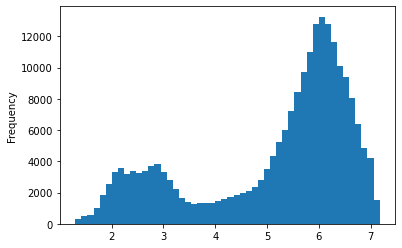

In [18]:
data_midas2 = data_midas.copy()
data_midas2 = data_midas2.drop(data_midas[txdata['first_txn']].index)
data_midas2['logscore'].plot.hist(bins=50)

In [19]:
# Fitting GMM to the remaining log scores distribution
gmm = mixture.GaussianMixture(n_components=2).fit(data_midas2['logscore'].values.reshape(-1,1))
gmm_probs = gmm.predict_proba(data_midas2['logscore'].values.reshape(-1,1))
gmm_means = gmm.means_
gmm_covs = gmm.covariances_
gmm_weights = gmm.weights_

Text(0.5, 1.0, 'GMM Fit of the Remaining Log10 Score Distribution')

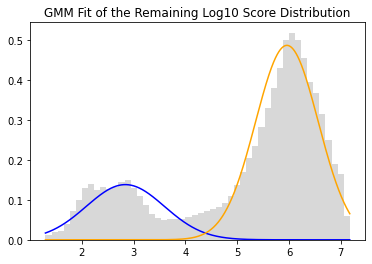

In [20]:
plt.hist(data_midas2['logscore'], bins=50, alpha=0.3, color='grey', density=True)

x_axis = np.ravel(data_midas2['logscore']).astype(np.float)
x_axis.sort()
plt.plot(x_axis,gmm_weights[0]*norm.pdf(x_axis,loc=gmm_means[0].ravel(),scale=np.sqrt(gmm_covs[0])).ravel(), c='orange' if gmm_means[0]>gmm_means[1] else 'blue')
plt.plot(x_axis,gmm_weights[1]*norm.pdf(x_axis,loc=gmm_means[1].ravel(),scale=np.sqrt(gmm_covs[1])).ravel(), c='blue' if gmm_means[1]<gmm_means[0] else 'orange')
plt.title('GMM Fit of the Remaining Log10 Score Distribution')

In [21]:
# Finding which column of the results represents the anomalous component
anomalous_col = gmm_means.argmax()

<AxesSubplot:ylabel='Frequency'>

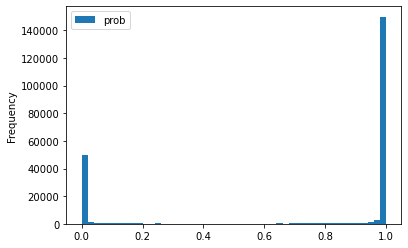

In [22]:
# Getting the probability of being anomalous
anomalous_df = pd.DataFrame(gmm_probs[:, anomalous_col])
anomalous_df.columns = ['prob']
anomalous_df.plot.hist(bins=50)

In [23]:
# Assigning the anomaly probabilities to the remaining txns
anomalous_df = anomalous_df.set_index(data_midas2.index)
txdata.loc[~txdata['first_txn'],['anomaly_prob']] = anomalous_df['prob']
txdata

,source,dest,time,first_txn,anomaly_prob
0,0,137,1,True,0.000000e+00
1,0,74,1,True,0.000000e+00
2,0,84,1,True,0.000000e+00
3,0,49,1,True,0.000000e+00
4,0,1275,1,True,0.000000e+00
...,...,...,...,...,...
316119,6795,6464,34872,False,5.501918e-07
316120,6697,6464,34872,False,8.408092e-07
316121,7833,6464,34873,False,1.223377e-06
316122,6464,32301,34873,True,0.000000e+00


### Exploring Wallets with the Highest Anomalous Probabilities

In [24]:
txdata2 = txdata.copy()
txdata3 = txdata2.rename(columns={'source': 'dest', 'dest': 'source'})
txdata2 = pd.concat([txdata2, txdata3]).reset_index(drop=True)
walletprobs = txdata2.groupby(['source']).agg({'anomaly_prob': ['max', 'mean']}).droplevel(0,axis=1).reset_index()
walletprobs

,source,max,mean
0,0,6.582532e-06,4.870944e-08
1,1,2.661345e-10,1.330672e-10
2,2,1.873271e-07,9.366356e-08
3,3,0.000000e+00,0.000000e+00
4,4,3.349674e-04,4.762558e-05
...,...,...,...
32298,32298,0.000000e+00,0.000000e+00
32299,32299,0.000000e+00,0.000000e+00
32300,32300,0.000000e+00,0.000000e+00
32301,32301,0.000000e+00,0.000000e+00


In [85]:
walletmap = pd.read_csv('data/tokenTx_2tiers_all_walletmap.csv', header=None, names=['wallet','source'])
walletmap

,wallet,source
0,0xf3d1f26b31db83c8899626746d0bbc59d9dd223c,0
1,0x4fc6044e44978cf9ea78eb43c2832416996c63ad,1
2,0xb8dcf450328f64182a2b3efbece2d072f558230a,2
3,0xaa92358737c1a59caee1a5114e1d1ef4c99498e2,3
4,0xe0a97c2634c0b1d2530b2f92e46697460692ca0c,4
...,...,...
32298,0xca265359f2e7466b755bbb6fccc63a07b05e656b,32298
32299,0xbc7dcf868a5f465d8e0f37ae52ef8cd8b569d178,32299
32300,0xd9a3b4cea7813cae12cf1c9e83829e631ef87831,32300
32301,0x84ff6064e303ddde2abec41dc1f3d5ce700564e7,32301


#### First highest-scored wallet A (max probability)

In [86]:
walletprobs[walletprobs['max'] == walletprobs['max'].nlargest(5).iloc[0]]['source']

3765    3765
5089    5089
Name: source, dtype: int64

In [87]:
walletid = 3765
print(walletmap[walletmap['source']==walletid]['wallet'])
txdata[(txdata['source']==walletid) | (txdata['dest']==walletid)].sort_values('time')

3765    0x9251dd446e4ddf929ff8fe0e994005c726e69446
Name: wallet, dtype: object


,source,dest,time,first_txn,anomaly_prob
27668,2135,3765,10778,True,0.000000e+00
28485,2160,3765,11317,True,0.000000e+00
29721,2205,3765,12151,True,0.000000e+00
53768,3506,3765,19543,True,0.000000e+00
56240,3506,3765,19556,False,4.880159e-01
...,...,...,...,...,...
304142,3765,30721,33332,True,0.000000e+00
310322,6385,3765,34038,False,1.558647e-02
311035,3765,27121,34053,False,4.826264e-07
312997,6385,3765,34703,False,5.064063e-01


In [88]:
# Counting the number of txns in the same hour
txdata[(txdata['source']==walletid) | (txdata['dest']==walletid)].groupby('time').count().sort_values('source', ascending=False)

,source,dest,first_txn,anomaly_prob
time,,,,
24633,15,15,15,15
23867,12,12,12,12
25277,11,11,11,11
23864,8,8,8,8
25272,6,6,6,6
...,...,...,...,...
25295,1,1,1,1
25297,1,1,1,1
25299,1,1,1,1


In [89]:
txdata[(txdata['dest']==walletid)].sort_values('time').groupby('time').count().sort_values('source', ascending=False)

,source,dest,first_txn,anomaly_prob
time,,,,
24633,15,15,15,15
23867,12,12,12,12
25277,11,11,11,11
23864,8,8,8,8
25272,6,6,6,6
...,...,...,...,...
24632,1,1,1,1
11317,1,1,1,1
25276,1,1,1,1


In [90]:
txdata[(txdata['source']==walletid)].sort_values('time').groupby('time').count().sort_values('source', ascending=False)

,source,dest,first_txn,anomaly_prob
time,,,,
20358,1,1,1,1
28264,1,1,1,1
34053,1,1,1,1
33332,1,1,1,1
32520,1,1,1,1
31939,1,1,1,1
31160,1,1,1,1
30460,1,1,1,1
29736,1,1,1,1


In [91]:
# Zooming into the hour with the highest number of txns where walletid was the receiver
txdata[(txdata['dest']==walletid) & (txdata['time']==24633)]

,source,dest,time,first_txn,anomaly_prob
165493,5091,3765,24633,False,0.999882
165516,5090,3765,24633,False,0.999894
165534,5089,3765,24633,False,0.999929
165851,5092,3765,24633,False,0.999945
166291,5093,3765,24633,False,0.999963
166822,5091,3765,24633,False,0.999982
166830,5091,3765,24633,False,0.999982
166831,5090,3765,24633,False,0.999982
166877,5090,3765,24633,False,0.999983
166879,5089,3765,24633,False,0.999988


#### First highest-scored wallet B (max probability)

In [92]:
walletprobs[walletprobs['max'] == walletprobs['max'].nlargest(5).iloc[1]]['source']

3765    3765
5089    5089
Name: source, dtype: int64

In [93]:
walletid = 5089
print(walletmap[walletmap['source']==walletid]['wallet'])
txdata[(txdata['source']==walletid) | (txdata['dest']==walletid)].sort_values('time')

5089    0x859f0b427b88a6c9d7bd0277ee87c2b00c2b5258
Name: wallet, dtype: object


,source,dest,time,first_txn,anomaly_prob
110927,5089,5499,23857,True,0.000000
110943,5089,24187,23857,True,0.000000
110942,5089,10400,23857,True,0.000000
110941,5089,22857,23857,True,0.000000
110939,5089,14254,23857,True,0.000000
...,...,...,...,...,...
228297,5089,2187,26070,False,0.999897
228298,5089,14153,26070,False,0.999898
228299,5089,197,26070,False,0.999898
228289,5089,5732,26070,False,0.999892


In [94]:
# Counting the number of txns in the same hour
txdata[(txdata['source']==walletid) | (txdata['dest']==walletid)].groupby('time').count().sort_values('source', ascending=False)

,source,dest,first_txn,anomaly_prob
time,,,,
26069,1884,1884,1884,1884
24632,1228,1228,1228,1228
24631,1189,1189,1189,1189
25276,1102,1102,1102,1102
24633,1041,1041,1041,1041
24634,1013,1013,1013,1013
25274,953,953,953,953
25275,924,924,924,924
23867,906,906,906,906


In [95]:
txdata[(txdata['dest']==walletid)].sort_values('time').groupby('time').count().sort_values('source', ascending=False)

,source,dest,first_txn,anomaly_prob
time,,,,


In [96]:
txdata[(txdata['source']==walletid)].sort_values('time').groupby('time').count().sort_values('source', ascending=False)

,source,dest,first_txn,anomaly_prob
time,,,,
26069,1884,1884,1884,1884
24632,1228,1228,1228,1228
24631,1189,1189,1189,1189
25276,1102,1102,1102,1102
24633,1041,1041,1041,1041
24634,1013,1013,1013,1013
25274,953,953,953,953
25275,924,924,924,924
23867,906,906,906,906


In [97]:
# Zooming into the hour with the highest number of txns where walletid was the receiver
txdata[(txdata['source']==walletid) & (txdata['time']==26069)]

,source,dest,time,first_txn,anomaly_prob
226140,5089,5642,26069,False,0.066286
226141,5089,5642,26069,False,0.070986
226142,5089,7366,26069,False,0.075928
226143,5089,4428,26069,False,0.081115
226144,5089,3580,26069,False,0.086553
...,...,...,...,...,...
228039,5089,5273,26069,False,0.999999
228040,5089,7171,26069,False,0.999999
228041,5089,5856,26069,False,0.999999
228042,5089,23911,26069,False,0.999999


In [98]:
len(txdata[(txdata['source']==walletid) & (txdata['time']==26069)]['dest'].unique())

1227

#### First highest-scored wallet (mean probability)

In [99]:
walletprobs[walletprobs['mean'] == walletprobs['mean'].nlargest(5).iloc[0]]['source']

7165    7165
Name: source, dtype: int64

In [100]:
walletid = 7165
print(walletmap[walletmap['source']==walletid]['wallet'])
txdata[(txdata['source']==walletid) | (txdata['dest']==walletid)].sort_values('time')

7165    0xc4573d7bdd1f08898be075bc5a3de85eed192984
Name: wallet, dtype: object


,source,dest,time,first_txn,anomaly_prob
75173,3506,7165,21556,True,0.000000
80273,3506,7165,21559,False,0.999998
81461,3506,7165,21559,False,1.000000
81604,3506,7165,21559,False,1.000000
85355,3506,7165,22281,False,0.999710
...,...,...,...,...,...
233048,5091,7165,26078,False,0.995698
234201,5091,7165,26079,False,0.999469
235179,5091,7165,26091,False,0.957491
238388,5092,7165,26094,False,0.998645


In [101]:
# Counting the number of txns in the same hour
txdata[(txdata['source']==walletid) | (txdata['dest']==walletid)].groupby('time').count().sort_values('source', ascending=False)

,source,dest,first_txn,anomaly_prob
time,,,,
23864,69,69,69,69
23867,54,54,54,54
23863,49,49,49,49
23862,38,38,38,38
23866,28,28,28,28
23865,25,25,25,25
23869,20,20,20,20
23868,18,18,18,18
24633,15,15,15,15


In [102]:
txdata[(txdata['dest']==walletid)].sort_values('time').groupby('time').count().sort_values('source', ascending=False)

,source,dest,first_txn,anomaly_prob
time,,,,
23864,69,69,69,69
23867,54,54,54,54
23863,49,49,49,49
23862,38,38,38,38
23866,28,28,28,28
23865,25,25,25,25
23869,20,20,20,20
23868,18,18,18,18
24633,15,15,15,15


In [103]:
txdata[(txdata['source']==walletid)].sort_values('time').groupby('time').count().sort_values('source', ascending=False)

,source,dest,first_txn,anomaly_prob
time,,,,
27959,1,1,1,1


In [104]:
# Zooming into the hour with the highest number of txns where walletid was the receiver
txdata[(txdata['dest']==walletid) & (txdata['time']==23864)]

,source,dest,time,first_txn,anomaly_prob
119760,5092,7165,23864,False,0.999954
119815,5091,7165,23864,False,0.999964
119896,5092,7165,23864,False,0.999970
120047,5092,7165,23864,False,0.999980
120096,5093,7165,23864,False,0.999984
...,...,...,...,...,...
123382,5091,7165,23864,False,1.000000
123446,5092,7165,23864,False,1.000000
123667,5092,7165,23864,False,1.000000
123670,5089,7165,23864,False,1.000000


#### Second highest-scored wallet (mean probability)

In [105]:
walletprobs[walletprobs['mean'] == walletprobs['mean'].nlargest(5).iloc[1]]['source']

4018    4018
Name: source, dtype: int64

In [106]:
walletid = 4018
print(walletmap[walletmap['source']==walletid]['wallet'])
txdata[(txdata['source']==walletid) | (txdata['dest']==walletid)].sort_values('time')

4018    0x43c2e11efd9b3efcc9b5b164a289c9a25e8a87fc
Name: wallet, dtype: object


,source,dest,time,first_txn,anomaly_prob
62026,3506,4018,20211,True,0.000000
65923,3506,4018,20865,False,0.942643
67092,3506,4018,20866,False,0.997783
71305,3506,4018,20868,False,0.999946
74038,3506,4018,21555,False,0.999531
...,...,...,...,...,...
200822,5089,4018,25277,False,0.999784
202267,5091,4018,25277,False,0.999958
231018,5091,4018,26076,False,0.992963
236476,5092,4018,26092,False,0.999671


In [107]:
txdata[(txdata['source']==walletid) | (txdata['dest']==walletid)].groupby('time').count().sort_values('source', ascending=False)

,source,dest,first_txn,anomaly_prob
time,,,,
24630,40,40,40,40
24632,33,33,33,33
23862,31,31,31,31
23863,29,29,29,29
24633,26,26,26,26
23867,25,25,25,25
23866,24,24,24,24
24634,21,21,21,21
23864,21,21,21,21


In [108]:
txdata[(txdata['dest']==walletid)].sort_values('time').groupby('time').count().sort_values('source', ascending=False)

,source,dest,first_txn,anomaly_prob
time,,,,
24630,40,40,40,40
24632,32,32,32,32
23862,31,31,31,31
23863,28,28,28,28
24633,26,26,26,26
23867,25,25,25,25
23866,23,23,23,23
23864,21,21,21,21
24634,20,20,20,20


In [109]:
txdata[(txdata['source']==walletid)].sort_values('time').groupby('time').count().sort_values('source', ascending=False)

,source,dest,first_txn,anomaly_prob
time,,,,
21559,1,1,1,1
22299,1,1,1,1
23068,1,1,1,1
23863,1,1,1,1
23866,1,1,1,1
23870,1,1,1,1
24632,1,1,1,1
24634,1,1,1,1


In [110]:
txdata[(txdata['dest']==walletid) & (txdata['time']==24630)]

,source,dest,time,first_txn,anomaly_prob
149364,5091,4018,24630,False,0.998988
149494,5093,4018,24630,False,0.999398
149811,5089,4018,24630,False,0.999839
150080,5093,4018,24630,False,0.999871
150115,5091,4018,24630,False,0.999819
150241,5093,4018,24630,False,0.999916
150358,5091,4018,24630,False,0.999894
150391,5089,4018,24630,False,0.999957
150393,5092,4018,24630,False,0.999739
150423,5090,4018,24630,False,0.999819


#### Third highest-scored wallet (mean probability)

In [111]:
walletprobs[walletprobs['mean'] == walletprobs['mean'].nlargest(5).iloc[2]]['source']

4428    4428
Name: source, dtype: int64

In [112]:
walletid = 4428
print(walletmap[walletmap['source']==walletid]['wallet'])
txdata[(txdata['source']==walletid) | (txdata['dest']==walletid)].sort_values('time')

4428    0x74756b75fc77896a88ba3544572ce1595d78d7d9
Name: wallet, dtype: object


,source,dest,time,first_txn,anomaly_prob
74454,3506,4428,21555,True,0.000000
78489,3506,4428,21558,False,1.000000
79197,3506,4428,21559,False,0.999963
79369,3506,4428,21559,False,0.999980
84485,3506,4428,22280,False,0.999956
...,...,...,...,...,...
235148,5091,4428,26091,False,0.921531
237186,5092,4428,26092,False,0.999990
240739,4428,5930,26518,True,0.000000
242882,6385,4428,26740,True,0.000000


In [113]:
txdata[(txdata['source']==walletid) | (txdata['dest']==walletid)].groupby('time').count().sort_values('source', ascending=False)

,source,dest,first_txn,anomaly_prob
time,,,,
24632,231,231,231,231
24633,221,221,221,221
25276,203,203,203,203
23867,175,175,175,175
25277,173,173,173,173
...,...,...,...,...
23066,1,1,1,1
22571,1,1,1,1
22321,1,1,1,1


In [114]:
txdata[(txdata['dest']==walletid)].sort_values('time').groupby('time').count().sort_values('source', ascending=False)

,source,dest,first_txn,anomaly_prob
time,,,,
24632,231,231,231,231
24633,221,221,221,221
25276,203,203,203,203
23867,175,175,175,175
25277,173,173,173,173
...,...,...,...,...
23069,1,1,1,1
23066,1,1,1,1
22321,1,1,1,1


In [115]:
txdata[(txdata['source']==walletid)].sort_values('time').groupby('time').count().sort_values('source', ascending=False)

,source,dest,first_txn,anomaly_prob
time,,,,
22571,1,1,1,1
23153,1,1,1,1
23930,1,1,1,1
24996,1,1,1,1
25528,1,1,1,1
25529,1,1,1,1
26518,1,1,1,1
27140,1,1,1,1


In [116]:
txdata[(txdata['dest']==walletid) & (txdata['time']==24632)]

,source,dest,time,first_txn,anomaly_prob
158739,5093,4428,24632,False,0.998517
158803,5093,4428,24632,False,0.998823
158810,5092,4428,24632,False,0.999516
158811,5089,4428,24632,False,0.999720
158865,5091,4428,24632,False,0.999313
...,...,...,...,...,...
164449,5091,4428,24632,False,0.999999
164471,5093,4428,24632,False,0.999999
164494,5093,4428,24632,False,0.999999
164583,5093,4428,24632,False,0.999999


#### Checking wallets with mean probability > 0.95

In [117]:
walletprobs[walletprobs['mean'] > 0.95]

,source,max,mean
4018,4018,1.0,0.950295
7165,7165,1.0,0.952691


In [118]:
# Getting the wallet address hash
walletmap[walletmap['source']==walletprobs[walletprobs['mean'] > 0.95]['source'].iloc[0]]['wallet'].iloc[0]

'0x43c2e11efd9b3efcc9b5b164a289c9a25e8a87fc'

In [119]:
walletid = walletprobs[walletprobs['mean'] > 0.95]['source'].iloc[0]
txdata[(txdata['source']==walletid) | (txdata['dest']==walletid)]

,source,dest,time,first_txn,anomaly_prob
62026,3506,4018,20211,True,0.000000
65923,3506,4018,20865,False,0.942643
67092,3506,4018,20866,False,0.997783
71305,3506,4018,20868,False,0.999946
74038,3506,4018,21555,False,0.999531
...,...,...,...,...,...
200822,5089,4018,25277,False,0.999784
202267,5091,4018,25277,False,0.999958
231018,5091,4018,26076,False,0.992963
236476,5092,4018,26092,False,0.999671


In [120]:
walletmap[walletmap['source']==walletprobs[walletprobs['mean'] > 0.95]['source'].iloc[1]]['wallet'].iloc[0]

'0xc4573d7bdd1f08898be075bc5a3de85eed192984'

In [121]:
walletid = walletprobs[walletprobs['mean'] > 0.95]['source'].iloc[1]
txdata[(txdata['source']==walletid) | (txdata['dest']==walletid)]

,source,dest,time,first_txn,anomaly_prob
75173,3506,7165,21556,True,0.000000
80273,3506,7165,21559,False,0.999998
81461,3506,7165,21559,False,1.000000
81604,3506,7165,21559,False,1.000000
85355,3506,7165,22281,False,0.999710
...,...,...,...,...,...
233048,5091,7165,26078,False,0.995698
234201,5091,7165,26079,False,0.999469
235179,5091,7165,26091,False,0.957491
238388,5092,7165,26094,False,0.998645


## Saving the Anomaly Probabilities of Wallets

In [122]:
walletprobs = walletprobs.merge(walletmap, how='left', on='source').drop(['source'], axis=1)
walletprobs

,max,mean,wallet
0,6.582532e-06,4.870944e-08,0xf3d1f26b31db83c8899626746d0bbc59d9dd223c
1,2.661345e-10,1.330672e-10,0x4fc6044e44978cf9ea78eb43c2832416996c63ad
2,1.873271e-07,9.366356e-08,0xb8dcf450328f64182a2b3efbece2d072f558230a
3,0.000000e+00,0.000000e+00,0xaa92358737c1a59caee1a5114e1d1ef4c99498e2
4,3.349674e-04,4.762558e-05,0xe0a97c2634c0b1d2530b2f92e46697460692ca0c
...,...,...,...
32298,0.000000e+00,0.000000e+00,0xca265359f2e7466b755bbb6fccc63a07b05e656b
32299,0.000000e+00,0.000000e+00,0xbc7dcf868a5f465d8e0f37ae52ef8cd8b569d178
32300,0.000000e+00,0.000000e+00,0xd9a3b4cea7813cae12cf1c9e83829e631ef87831
32301,0.000000e+00,0.000000e+00,0x84ff6064e303ddde2abec41dc1f3d5ce700564e7


In [123]:
walletprobs.to_csv('data/midas_wallet_anomalousProbs.csv', index=False)